# Detection of COVID-19

### Importing Libraries

In [3]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time
import tensorflow as tf
import seaborn as sns


import keras
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from keras.layers import  Flatten, Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
import os 
import cv2

folder1 = "COVID-19_Radiography_Dataset\\COVID\\images"
folder2 = "COVID-19_Radiography_Dataset\\Normal\\images"
folder3 = "COVID-19_Radiography_Dataset\\Viral Pneumonia\\images"

def load_images_from_folder(folder, num):
    images = []
    y = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename));
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = cv2.resize(img,(128,128))
        if img is not None:
            images.append(img)
            y.append(num)
    return images , y

OriginalCovidImages, class1 = load_images_from_folder(folder1,0)
OriginalNormalImages, class3 = load_images_from_folder(folder2,2)
OriginalViralPneumoniaImages, class2 = load_images_from_folder(folder3,1)


In [ ]:
def reshapeimages(images, y):
    images = np.array(images)
    y = np.array(y).reshape(-1,1)
    return images, y

In [ ]:
OriginalCovidImages, class1 = reshapeimages(OriginalCovidImages,class1)
OriginalViralPneumoniaImages, class2 = reshapeimages(OriginalViralPneumoniaImages,class2)
OriginalNormalImages, class3 = reshapeimages(OriginalNormalImages,class3)

print(len(OriginalCovidImages))
print(OriginalCovidImages.shape)
print(class1.shape)

3616
(3616, 128, 128, 3)
(3616, 1)


In [ ]:
Covid_train, Covid_test, class1_train, class1_test = train_test_split(OriginalCovidImages,class1, test_size=0.1, random_state=42)
Covid_test, Covid_val, class1_test, class1_val = train_test_split(Covid_test, class1_test, test_size=0.2, random_state=42)
print(Covid_train.shape)
print(Covid_val.shape)
print(Covid_test.shape)

(3254, 128, 128, 3)
(73, 128, 128, 3)
(289, 128, 128, 3)


In [ ]:
ViralP_train, ViralP_test, class2_train, class2_test = train_test_split(OriginalViralPneumoniaImages,class2, test_size=0.1, random_state=42)
ViralP_test, ViralP_val, class2_test, class2_val = train_test_split(ViralP_test, class2_test, test_size=0.2, random_state=42)
print(ViralP_train.shape)
print(ViralP_val.shape)
print(ViralP_test.shape)

(1210, 128, 128, 3)
(27, 128, 128, 3)
(108, 128, 128, 3)


In [ ]:
Normal_train, Normal_test, class3_train, class3_test = train_test_split(OriginalNormalImages,class3, test_size=0.1, random_state=42)
Normal_test, Normal_val, class3_test, class3_val = train_test_split(Normal_test, class3_test, test_size=0.2, random_state=42)
print(Normal_train.shape)
print(Normal_val.shape)
print(Normal_test.shape)

(9172, 128, 128, 3)
(204, 128, 128, 3)
(816, 128, 128, 3)


## Final Train Test Validation set

In [ ]:
X_train = np.concatenate((Covid_train, ViralP_train, Normal_train), axis=0) 
y_train = np.concatenate((class1_train, class2_train, class3_train), axis=0) 
X_test = np.concatenate((Covid_test, ViralP_test, Normal_test), axis=0) 
y_test = np.concatenate((class1_test, class2_test, class3_test), axis=0) 
X_val = np.concatenate((Covid_val, ViralP_val, Normal_val), axis=0) 
y_val = np.concatenate((class1_val, class2_val, class3_val), axis=0) 


In [ ]:
print(X_train.shape)
print(X_train)

(13636, 128, 128, 3)
[[[[2.05112366e+02 2.05112366e+02 2.05112366e+02]
   [6.08111877e+01 6.08111877e+01 6.08111877e+01]
   [4.10047913e+01 4.10047913e+01 4.10047913e+01]
   ...
   [3.32031250e-01 3.32031250e-01 3.32031250e-01]
   [3.32031250e-01 3.32031250e-01 3.32031250e-01]
   [3.32031250e-01 3.32031250e-01 3.32031250e-01]]

  [[1.78754044e+02 1.78754044e+02 1.78754044e+02]
   [9.07026672e+00 9.07026672e+00 9.07026672e+00]
   [3.74298096e-02 3.74298096e-02 3.74298096e-02]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  [[1.09172974e+02 1.09172974e+02 1.09172974e+02]
   [8.64795990e+01 8.64795990e+01 8.64795990e+01]
   [6.91445007e+01 6.91445007e+01 6.91445007e+01]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  ...

  [[1.39426666e+02 1.39426666e+02 1.39426666e

In [ ]:
X_train = X_train /255
X_test_scaled = X_test / 255
X_val = X_val/255

In [ ]:
print(X_train.shape)
print(X_train)

(13636, 128, 128, 3)
[[[[8.04362237e-01 8.04362237e-01 8.04362237e-01]
   [2.38475248e-01 2.38475248e-01 2.38475248e-01]
   [1.60803109e-01 1.60803109e-01 1.60803109e-01]
   ...
   [1.30208337e-03 1.30208337e-03 1.30208337e-03]
   [1.30208337e-03 1.30208337e-03 1.30208337e-03]
   [1.30208337e-03 1.30208337e-03 1.30208337e-03]]

  [[7.00996220e-01 7.00996220e-01 7.00996220e-01]
   [3.55696753e-02 3.55696753e-02 3.55696753e-02]
   [1.46783568e-04 1.46783568e-04 1.46783568e-04]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  [[4.28129315e-01 4.28129315e-01 4.28129315e-01]
   [3.39135677e-01 3.39135677e-01 3.39135677e-01]
   [2.71154910e-01 2.71154910e-01 2.71154910e-01]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  ...

  [[5.46771228e-01 5.46771228e-01 5.46771228e

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable=False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 1

In [ ]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test= np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = 0.00001
decay_steps = 10
decay_rate = 1


lr_schedular = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps, decay_rate)
optimizer1 = tf.keras.optimizers.Adam(learning_rate=lr_schedular)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer = optimizer1, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train,y_train, batch_size=32,epochs=40, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/40
427/427 [==============================] - 718s 2s/step - loss: 0.3976 - accuracy: 0.8425 - val_loss: 0.2573 - val_accuracy: 0.9079
Epoch 2/40
427/427 [==============================] - 698s 2s/step - loss: 0.2008 - accuracy: 0.9307 - val_loss: 0.2007 - val_accuracy: 0.9145
Epoch 3/40
427/427 [==============================] - 679s 2s/step - loss: 0.1564 - accuracy: 0.9459 - val_loss: 0.1745 - val_accuracy: 0.9342
Epoch 4/40
427/427 [==============================] - 692s 2s/step - loss: 0.1311 - accuracy: 0.9568 - val_loss: 0.1596 - val_accuracy: 0.9375
Epoch 5/40
427/427 [==============================] - 692s 2s/step - loss: 0.1127 - accuracy: 0.9630 - val_loss: 0.1500 - val_accuracy: 0.9375
Epoch 6/40
427/427 [==============================] - 685s 2s/step - loss: 0.0986 - accuracy: 0.9681 - val_loss: 0.1307 - val_accuracy: 0.9441
Epoch 7/40
427/427 [==============================] - 615s 1s/step - loss: 0.0882 - accuracy: 0.9722 - val_loss: 0.1315 - val_accuracy: 0.9441

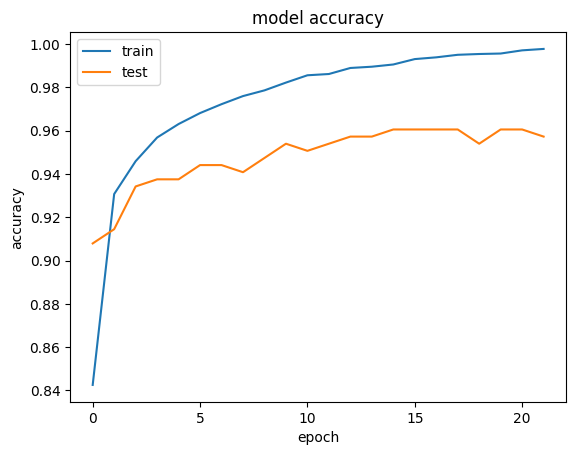

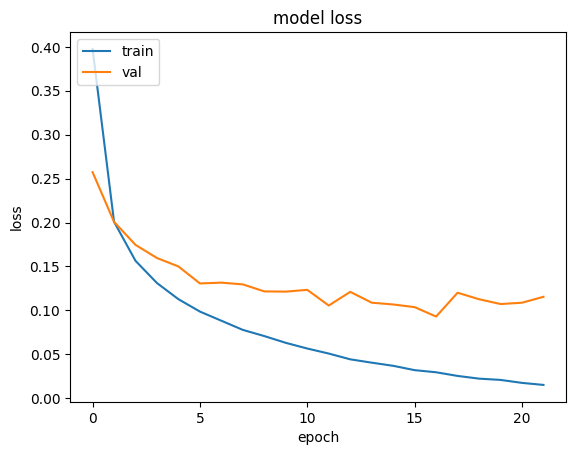

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

In [ ]:
model.save('model2.h5')

In [ ]:
model1 = model

In [ ]:
y_hat = model1.predict(X_test_scaled)

38/38 [==============================] - 44s 1s/step


In [ ]:
print(y_hat)

[[9.9849379e-01 1.9415522e-04 5.5307853e-01]
 [9.8833114e-01 2.4191119e-02 9.1834664e-02]
 [9.9540973e-01 1.6196263e-01 2.8477125e-03]
 ...
 [1.3649722e-03 8.8887829e-01 9.9547106e-01]
 [4.9323037e-01 1.5846799e-03 9.9687803e-01]
 [5.6828044e-02 8.0954109e-04 9.9991053e-01]]


In [ ]:
y_pred = y_hat.round()
print(y_pred)

[[1. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [ ]:
print(y_test)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

0.7131079967023908


In [ ]:
labels = ['Covid', 'Viral Pneumonia', 'Normal']
report = classification_report(y_test, y_pred, target_names=labels)
print(report)
print(f"Accuracy: {accuracy}")

                 precision    recall  f1-score   support

          Covid       0.62      0.99      0.76       289
Viral Pneumonia       0.61      1.00      0.76       108
         Normal       0.88      1.00      0.94       816

      micro avg       0.78      0.99      0.87      1213
      macro avg       0.71      0.99      0.82      1213
   weighted avg       0.80      0.99      0.88      1213
    samples avg       0.85      0.99      0.90      1213

Accuracy: 0.7131079967023908


[[285   2   2]
 [  4 104   0]
 [169  66 581]]


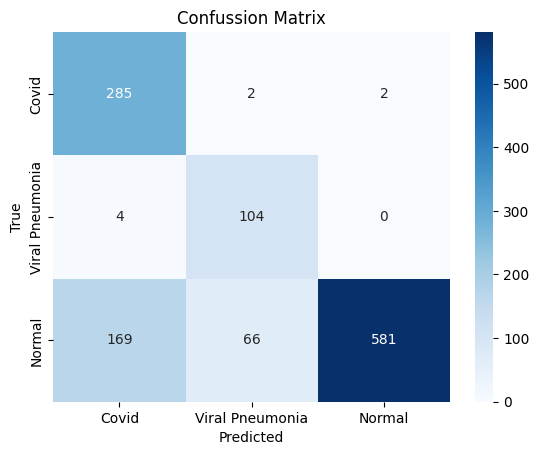

In [ ]:
cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

tick_labels = ['Covid', 'Viral Pneumonia', 'Normal']
plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confussion Matrix')
plt.show()